In [70]:
!pip install -Uqq fastai duckduckgo_search

# DDG API documentation
# https://pypi.org/project/duckduckgo-search/#3-images---image-search-by-duckduckgocom
from fastcore.all import *
from duckduckgo_search import ddg_images
from fastdownload import download_url
from fastai.vision.all import *
from duckduckgo_search import DDGS
import os

In [71]:
# helpful functions to DRY

# need to make sure this is closed later on
def search_ddg(search_terms):
    ddgs = DDGS()
    return ddgs.images(
        keywords = search_terms,
        region="wt-wt",
        safesearch="moderate",
        type_image="photo",
    )

In [72]:
categories = 'dolphin', 'manatee', 'turtle', 'whale', 'apple', 'orange', 'cherry'
generators = {}
for category in categories:
    generators[category] = search_ddg(category)
    
print(next(generators['turtle']))

{'title': 'File:Baby turtle.jpg', 'image': 'http://upload.wikimedia.org/wikipedia/commons/e/ea/Baby_turtle.jpg', 'thumbnail': 'https://tse3.mm.bing.net/th?id=OIP.qpWzbcnEVD5hkA0KYlcS7wHaE7&pid=Api', 'url': 'http://commons.wikimedia.org/wiki/File:Baby_turtle.jpg', 'height': 2000, 'width': 3008, 'source': 'Bing'}


Just for fun, download a few images

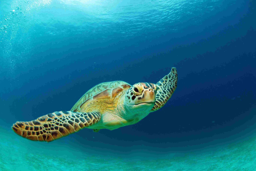

In [73]:
for category in categories:
    gen = generators[category]
    name = category + '.jpg'
    download_url(next(gen)['image'], name, show_progress=False)
    Image.open(name).to_thumb(256,256)

Image.open('turtle.jpg').to_thumb(256,256)

In [74]:
def get_n_urls (generator, n):
    items=[]
    for i in range(n):
        try:
            items.append(next(generator)['image'])
        except StopIteration:
            break
    return items

## *WARNING* - If you have bad data and want to replace it you may need to delete the files. New files are not downloaded if the folder has >=50. Or you could change the value of images_per_folder

This is not perfect as the ddg_search sometimes returns less than the number of items requested. But it will prevent wasting time downloading pictures to an extent.

In [75]:
images_per_folder = 50 # how many images each search attempts to download

path = Path('lesson1/training_images')

for category in categories:
    dest = (path/category)
    dest.mkdir(exist_ok=True, parents=true)
    if len(os.listdir(str(dest))) < images_per_folder:
        print(f"downloading {category}")
        gen = generators[category]
        download_images(dest, urls=get_n_urls(gen, images_per_folder))
        resize_images(path/category, max_size=400, dest=path/category)

In [76]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

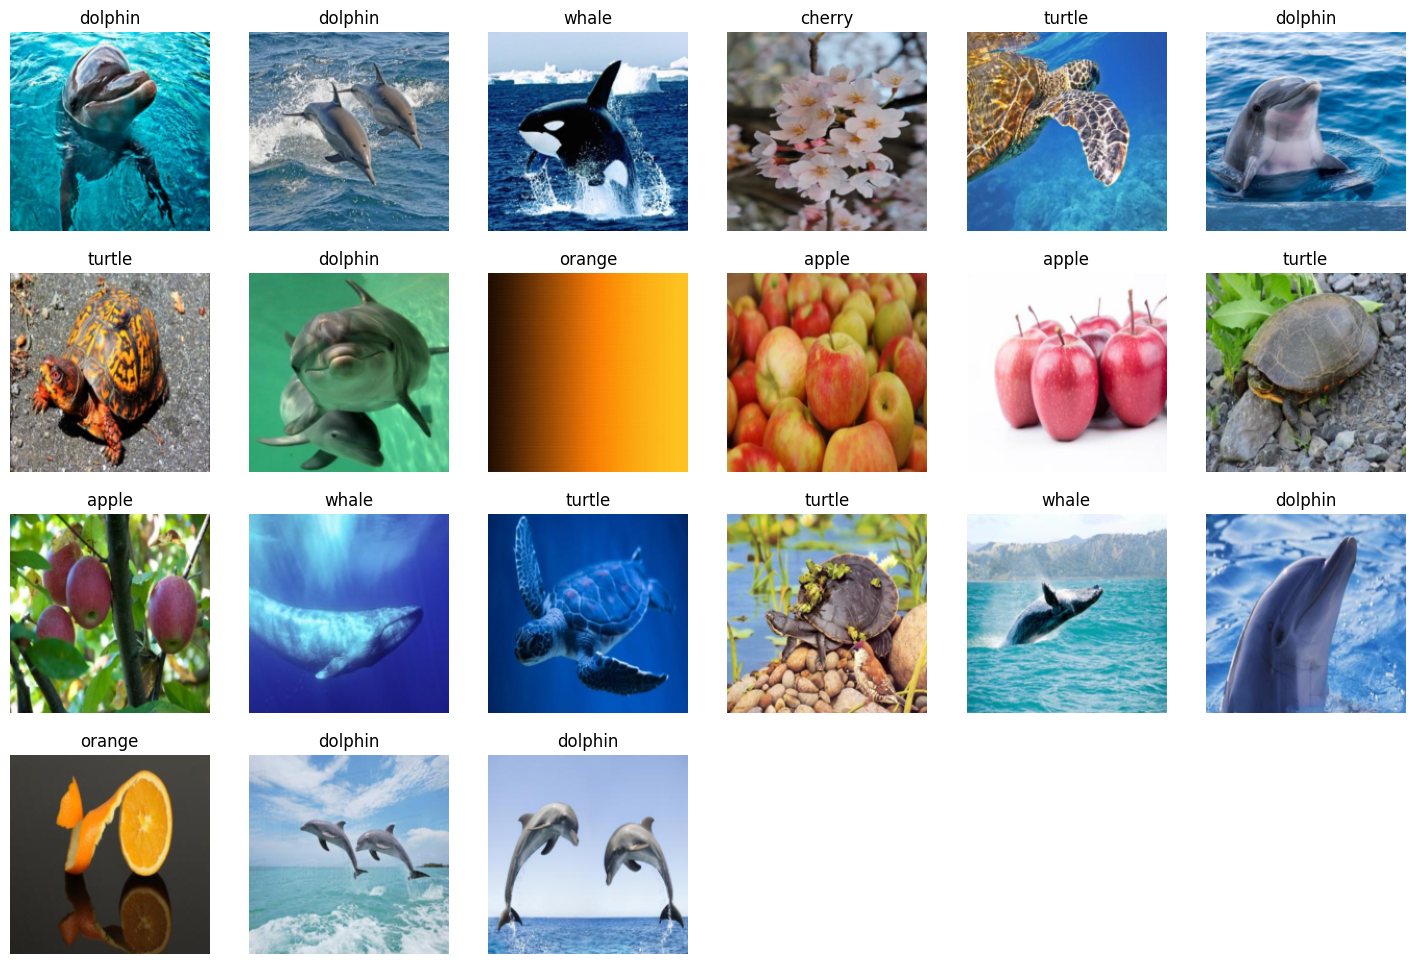

In [77]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=len(categories) * 3)

In [78]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Some helper code to get the subdirectories since the `path` passed into `dls` is based on the alphabetical directory names

In [79]:
def get_subdirectories(directory):
    return [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

# Usage
directories=get_subdirectories('lesson1/training_images')
print(directories)  # Replace with your directory
print(sorted(directories))
print(categories)

['orange', 'dolphin', 'cherry', 'whale', 'turtle', 'manatee', 'apple']
['apple', 'cherry', 'dolphin', 'manatee', 'orange', 'turtle', 'whale']
('dolphin', 'manatee', 'turtle', 'whale', 'apple', 'orange', 'cherry')


probs[i] returns the alphabetical order of the folder names that have the images. so something beginning with 'a' will have a lower index than something beginning with 'z'. 

In [80]:
for category in categories:
    is_x,_,probs = learn.predict(PILImage.create(f"{category}.jpg"))
    print(f"This is a {category}")
    for i in range(len(categories)):
        cat = sorted(categories)[i] #sorting this to match the order of the subdirectories of path in .dataloaders(path
        print(f"Probability it's a {cat}: {probs[i]:.4f}")

This is a dolphin
Probability it's a apple: 0.0000
Probability it's a cherry: 0.0008
Probability it's a dolphin: 0.9817
Probability it's a manatee: 0.0000
Probability it's a orange: 0.0001
Probability it's a turtle: 0.0000
Probability it's a whale: 0.0173


This is a manatee
Probability it's a apple: 0.0002
Probability it's a cherry: 0.0017
Probability it's a dolphin: 0.0398
Probability it's a manatee: 0.9523
Probability it's a orange: 0.0002
Probability it's a turtle: 0.0059
Probability it's a whale: 0.0000


This is a turtle
Probability it's a apple: 0.0000
Probability it's a cherry: 0.0003
Probability it's a dolphin: 0.0000
Probability it's a manatee: 0.0013
Probability it's a orange: 0.0010
Probability it's a turtle: 0.9969
Probability it's a whale: 0.0005


This is a whale
Probability it's a apple: 0.0001
Probability it's a cherry: 0.0005
Probability it's a dolphin: 0.0004
Probability it's a manatee: 0.0006
Probability it's a orange: 0.0000
Probability it's a turtle: 0.0003
Probability it's a whale: 0.9981


This is a apple
Probability it's a apple: 1.0000
Probability it's a cherry: 0.0000
Probability it's a dolphin: 0.0000
Probability it's a manatee: 0.0000
Probability it's a orange: 0.0000
Probability it's a turtle: 0.0000
Probability it's a whale: 0.0000


This is a orange
Probability it's a apple: 0.0014
Probability it's a cherry: 0.0001
Probability it's a dolphin: 0.0000
Probability it's a manatee: 0.0001
Probability it's a orange: 0.9983
Probability it's a turtle: 0.0000
Probability it's a whale: 0.0000


This is a cherry
Probability it's a apple: 0.1015
Probability it's a cherry: 0.8982
Probability it's a dolphin: 0.0000
Probability it's a manatee: 0.0000
Probability it's a orange: 0.0001
Probability it's a turtle: 0.0002
Probability it's a whale: 0.0000


Lastly, we need to close all the generators used

In [81]:
map(lambda g: g.close(), generators.values())
